Files needed for this demo:
* tabulated_logE_sindec_aeff_full.pckl
* bckg_flux_vals.pickle
* energy_smearing_kde.pckl
* e_psi_grid.pickle

# Imports

In [145]:
import pickle
import numpy as np
import warnings
import healpy as hp
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from scipy.interpolate import RegularGridInterpolator
warnings.filterwarnings("ignore")


In [146]:
from matplotlib.colors import LogNorm
plt.set_cmap("cividis")

<Figure size 432x288 with 0 Axes>

# Source parameters

In [147]:
# livetime of 10yrs in seconds
'''LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3
delta_psi = 4'''


LIVETIME = 365 * 10 * 86400
# Normalization energy of power law (E/E0)^gamma
E0 = 1e3
# Source flux spectral index
GAMMA = 3.2
PHI_0 = 5e-14 # neutrinos * (E/E0)^gamma / GeV / cm^2 / s
# source declination
SRC_DEC = np.radians(-1) # radian => source at horizon

# analysis region in distance to source
delta_psi = .45 /2 

In [148]:
pi0_norm =5.47e-13 #1.9e-16 #2.43e-18  #unbias corrected bias corrected 2.18e-18 #1/(GeV s  cm^2)
pi0_spectrum = 2
E0 = 1e3
GAMMA = 2

In [149]:
pi0_weight_per_bin = np.load('/home/steve/pone/templates/Fermi-LAT_pi0_map.npy', encoding='latin1')
pi0_flux_per_pixel = pi0_norm * pi0_weight_per_bin * hp.nside2pixarea(128) 

In [150]:
nside=128

In [151]:
sum(pi0_flux_per_pixel)

5.469999999999919e-13

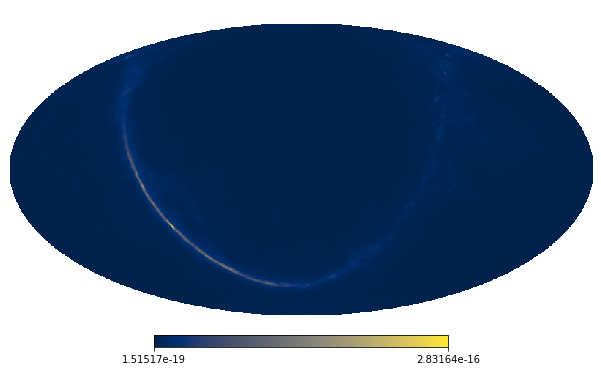

In [152]:
hp.mollview (pi0_flux_per_pixel, rot=(180,0), title=' ')

# Functions

In [153]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [154]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in true energy to reconstructed energy"""
    return (ematrix @ ev.T).T

In [155]:
def atmo_background(aeff_factor, bckg_flux_vals):
    """Calculate the number of neutrinos of atmospheric background flux as a function reconstructed energy"""
    return energy_smearing(normed_kvals, aeff_factor * bckg_flux_vals)


In [156]:
def array_source_interp(dec, array):
    """Take a 2D array and interpolate its values
    based on a value (dec) on the second axis"""
    low_ind = np.digitize(np.sin(dec), coszen_bins) - 1

    if low_ind >= (len(coszen_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if coszen_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [coszen_mids[low_ind], coszen_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


# Get the effective area

In [157]:
#h2d = np.load('/home/steve/pone/data/PONE_nu_effa_70_string.npy', allow_pickle=True)[()]
h2d = np.load('/home/steve/pone/data/pstracks_nu_effa.npy', allow_pickle=True)[()]
h2d

Hist(25 bins in [2.0,7.000000000000004], 49 bins in [-1.0,1.0], with sum 139349.20802387004, 88 empty bins, and 0 non-finite values)

In [158]:
logE_bins = h2d.bins[0]
coszen_bins = h2d.bins[1]
aeff_2d = 1e4*h2d.values #values are in m^2 not cm^2 ?? is this necessary?

In [159]:
# use only upgoing data to mimick up-going muon track data set
#with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
#    logE_bins, sindec_bins, aeff_2d = pickle.load(f)
#h2d = np.load('/home/steve/pone/data/PONE_nu_effa_70_string.npy')
#logE_bins = h2d.bins

logE_mids = get_mids(logE_bins)
# cut at E=10⁹GeV
logE_bins = logE_bins
aeff_2d = aeff_2d
logE_mids = logE_mids


ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

coszen_mids = get_mids(coszen_bins)
coszen_width = np.diff(coszen_bins)

print(len(emids), "log_10(energy) bins")
print(len(coszen_mids), "declination bins")


25 log_10(energy) bins
49 declination bins


(2.0, 7.0)

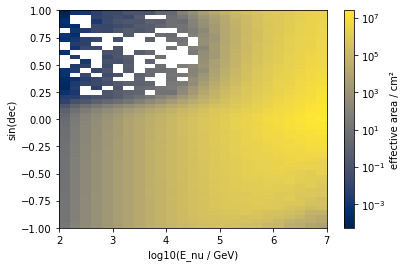

In [160]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

# Background

In [161]:
# MCEQ
with open("/home/steve/pone/Plenum/resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(coszen_mids, emids)
bckg_flux_vals = np.exp(rgi((em, ss))).T

(2.0, 7.0)

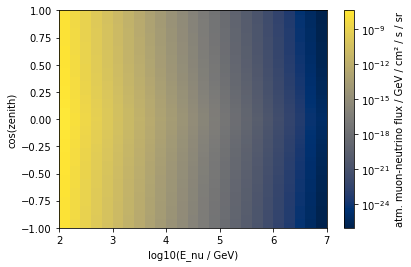

In [162]:
plt.pcolormesh(logE_bins, coszen_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("cos(zenith)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

# Energy smearing

In [163]:
#Using based energy smearing paramaterization??

In [164]:
# energy smearing matrix
with open("/home/steve/pone/Plenum/resources/energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 7.02, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
normed_kvals = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)

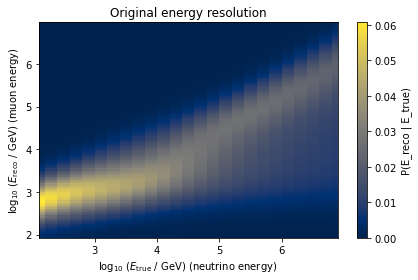

In [165]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

f, axes = plt.subplots()

axes.grid(False)
im = axes.pcolormesh(egrid_true, egrid_reco, normed_kvals)
axes.set_ylim(np.min(egrid_reco), np.max(egrid_reco))
axes.set_xlim(np.min(egrid_true), np.max(egrid_true))
axes.set_title("Original energy resolution")
axes.set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes.set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
cb = f.colorbar(im)
cb.set_label("P(E_reco | E_true)")
f.tight_layout()

# Source flux definition

In [166]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
    PHI_0 = PHI_0
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-14
    """
    tmp = aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling
    return energy_smearing(normed_kvals, tmp)

# calculate number of events per source as crosscheck

(should be 39.6 events in total)

In [167]:
pi0_norm

5.47e-13

In [168]:
aeff_factor_signal = (
    array_source_interp(SRC_DEC, aeff_2d) * LIVETIME * ewidth
)
# this is only 1D in energy dimension
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    E0,
    GAMMA,
    1,
    PHI_0=max(pi0_flux_per_pixel),
)
print(np.sum(k_s))


5.897989135782323


In [169]:
k_s.shape

(102,)

# Psi-Energy histogram

Going 2D now with angular distance 'Psi'

In [170]:
#delta_psi = np.degrees(hp.nside2pixarea(128)) #2 
delta_psi = .45 / 2
psi2_bins = np.linspace(0, delta_psi**2, 2**2 * 25 + 1)

In [171]:
np.degrees(hp.nside2pixarea(128))**2*25

0.00033527612686157216

In [172]:
with open("/home/steve/pone/Plenum//resources/e_psi_grid.pickle", "rb") as f:
    # 2D histogram in log(E) and psi²
    e_psi2_grid = pickle.load(f)
# cut to right size in energy
e_psi2_grid = e_psi2_grid[:, :len(logE_mids)]

In [173]:
e_psi2_grid.shape

(100, 25)

In [174]:
e_psi2_grid[:, :]

array([[3.29770274e-02, 3.80147416e-02, 4.44557064e-02, ...,
        3.87428755e-01, 3.95979239e-01, 4.00372775e-01],
       [3.09286392e-02, 3.50600307e-02, 4.00889679e-02, ...,
        1.41387807e-01, 1.41607025e-01, 1.43743781e-01],
       [2.87974898e-02, 3.20554775e-02, 3.60835561e-02, ...,
        8.53369485e-02, 8.53197151e-02, 8.46419609e-02],
       ...,
       [3.79382376e-03, 3.42514562e-03, 3.05230909e-03, ...,
        3.82043246e-04, 3.74277028e-04, 3.72012667e-04],
       [3.74936849e-03, 3.38353434e-03, 3.01366368e-03, ...,
        3.74926379e-04, 3.67508006e-04, 3.65609407e-04],
       [3.70581244e-03, 3.34279524e-03, 2.97584078e-03, ...,
        3.68018601e-04, 3.60944523e-04, 3.59399846e-04]])

In [175]:
e_psi2_grid[: , :40].shape


(100, 25)

In [176]:
# Background is uniform in psi²
# so we generate a matching uniform histogram here
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)


### Full nominal (=Asimov) histograms in Psi - log(E)

Fit parameters for analysis:
* Global normalization of k_b
* Global normalization of k_s
* Spectral index of k_s (=gamma)

In [177]:
dec = np.radians(60)
aeff_factor_signal = (
        array_source_interp(dec, aeff_2d)*  LIVETIME * ewidth
        )    
    
aeff_factor_bckg = (
        array_source_interp(dec, aeff_2d)
        * LIVETIME
        * ewidth
        * hp.nside2pixarea(128, degrees=False))

In [178]:
print(aeff_factor_bckg.shape)
print(aeff_factor_signal.shape)

(25,)
(25,)


[]

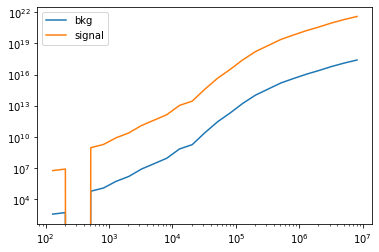

In [179]:
plt.plot(emids, aeff_factor_bckg, label='bkg')
plt.plot(emids, aeff_factor_signal, label='signal')
plt.legend()
plt.loglog()

In [274]:
n_sig = np.ndarray((len(pi0_flux_per_pixel), 102))
n_bkg = np.ndarray((len(pi0_flux_per_pixel), 102))
k_b_tot = np.zeros((100,102))
k_s_tot = np.zeros((100,102))

for pix, flux in enumerate(pi0_flux_per_pixel):
    theta, phi = hp.pix2ang(nside, pix)
    dec = np.pi/2 - theta
    ra = phi
    sindec = np.sin(dec)
    if (pix % 10000 == 0):
        print('\r Pixel: {} / {}     {:.2f}%           '.format(pix, 
                                                               hp.nside2npix(128), 
                                                               100.*pix/hp.nside2npix(128)), 
              end='', 
              flush =True)
    elif pix == len(pi0_flux_per_pixel) - 1:
            print('\r Pixel: {} / {}     {:.2f}%           '.format(pix + 1, 
                                                               hp.nside2npix(128), 
                                                               100.*pix/hp.nside2npix(128)), 
              end='', 
              flush =True)
            
    aeff_factor_signal = (
        array_source_interp(dec, aeff_2d)*  LIVETIME * ewidth #* e_psi2_grid
        )    

    k_s = astro_flux(
        aeff_factor_signal, #what to do here?  
        emids,
        E0,
        pi0_spectrum,
        1,
        PHI_0=flux,
        #smear_energy=False,
    )
    #k_s_final = np.append(k_s_final, k_s)
    #n_sig[pix] = k_s
    k_s_tot = np.add(k_s_tot ,k_s)
    aeff_factor_bckg = (
        array_source_interp(dec, aeff_2d)
        * LIVETIME
        * ewidth
        * hp.nside2pixarea(128, degrees=False) # solid angle approx.
    )* bckg_grid * 1
    k_b = atmo_background(aeff_factor_bckg, array_source_interp(dec, bckg_flux_vals.T).T)
    #print('k_b {}'.format(k_b.shape))
    #n_bkg[pix] = k_b
    k_b_tot = np.add(k_b_tot,k_b)
    '''test'''
    '''aeff_factor_bckg = (
    array_source_interp(SRC_DEC, aeff_2d)
    * LIVETIME
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
    ) * bckg_grid * 1 ## nominal value, FIT PARAMETER

    aeff_factor_signal = (
        array_source_interp(SRC_DEC, aeff_2d)* LIVETIME * ewidth * e_psi2_grid
    )
    # model expectation before adding fit parameters
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)'''

'''    # asimov data
    k_b = atmo_background(aeff_factor_bckg, array_source_interp(SRC_DEC, bckg_flux_vals.T).T)
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        E0,
        GAMMA, ## FIT PARAMETER
        1, ## FIT PARAMETER
    )'''
k_i = k_s_tot + k_b_tot
print('\n')
print("Asimov data sum:")
print("Background:", np.sum(k_b_tot)) # ~550
print("Signal:", np.sum(k_s_tot)) # ~40
print("S+B", np.sum(k_i)) # ~590

 Pixel: 196608 / 196608     100.00%           

Asimov data sum:
Background: 710624.4037819083
Signal: 534981.0608384354
S+B 1245605.4646203436


In [ ]:
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

In [275]:
print(k_b_tot.shape)
print(k_s_tot.shape)

(100, 102)
(100, 102)


In [ ]:
k_b = k_b_tot
k_s = k_s_tot

In [ ]:
k_i = k_b + k_s

In [273]:
k_

array([[4.73326099e-03, 6.22607446e-03, 8.12510255e-03, ...,
        5.47257035e-09, 3.83577639e-09, 2.62107470e-09],
       [4.73326099e-03, 6.22607446e-03, 8.12510255e-03, ...,
        5.47257035e-09, 3.83577639e-09, 2.62107470e-09],
       [4.73326099e-03, 6.22607446e-03, 8.12510255e-03, ...,
        5.47257035e-09, 3.83577639e-09, 2.62107470e-09],
       ...,
       [4.73326099e-03, 6.22607446e-03, 8.12510255e-03, ...,
        5.47257035e-09, 3.83577639e-09, 2.62107470e-09],
       [4.73326099e-03, 6.22607446e-03, 8.12510255e-03, ...,
        5.47257035e-09, 3.83577639e-09, 2.62107470e-09],
       [4.73326099e-03, 6.22607446e-03, 8.12510255e-03, ...,
        5.47257035e-09, 3.83577639e-09, 2.62107470e-09]])

In [185]:
'''print("Asimov data sum:")
print("Background:", np.sum(k_b)) # ~550
print("Signal:", np.sum(k_s)) # ~40
print("S+B", np.sum(k_i)) # ~590
'''

'print("Asimov data sum:")\nprint("Background:", np.sum(k_b)) # ~550\nprint("Signal:", np.sum(k_s)) # ~40\nprint("S+B", np.sum(k_i)) # ~590\n'

In [186]:
print(PHI_0)

5e-14


In [272]:
delta_psi = 2
aeff_factor_bckg = (
    array_source_interp(np.radians(1), aeff_2d)
    * LIVETIME
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
) * bckg_grid * 1 ## nominal value, FIT PARAMETER

aeff_factor_signal = (
    array_source_interp(np.radians(1), aeff_2d)* LIVETIME * ewidth * e_psi2_grid
)
# model expectation before adding fit parameters
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

# asimov data
k_b = atmo_background(aeff_factor_bckg, array_source_interp(np.radians(1), bckg_flux_vals.T).T)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    1e3,
    3.2, ## FIT PARAMETER
    1, ## FIT PARAMETER
    5e-14
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b)) # ~550
print("Signal:", np.sum(k_s)) # ~40
print("S+B", np.sum(k_i)) # ~590


Asimov data sum:
Background: 495.5329226912757
Signal: 81.68124456339945
S+B 577.2141672546751


In [264]:
print(k_b.shape)
print(k_s.shape)

(100, 102)
(100, 102)


## some plotting

In [254]:
delta_psi = .45 / 2
psi2_bins = np.linspace(0, delta_psi**2, 2**2 * 25 + 1)

Text(0.5, 1.0, 'Signal point-source flux')

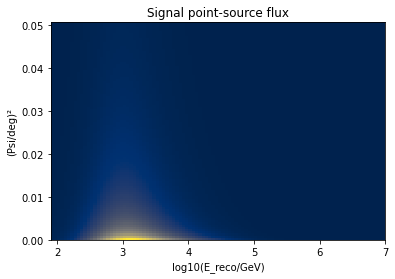

In [255]:
plt.pcolormesh(logE_reco_bins, psi2_bins, k_s)
plt.ylabel("(Psi/deg)²")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Signal point-source flux")

Text(0.5, 1.0, 'Background atmospheric flux')

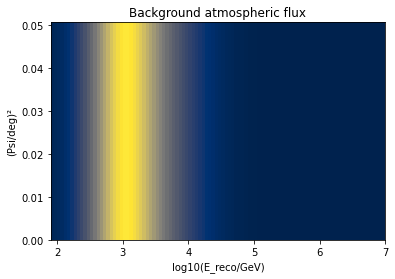

In [256]:
plt.pcolormesh(logE_reco_bins, psi2_bins, k_b)
plt.ylabel("(Psi/deg)²")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Background atmospheric flux")

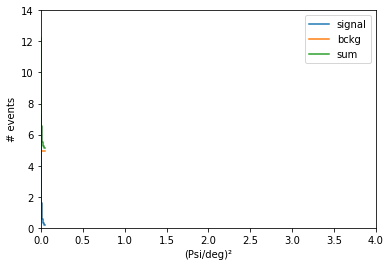

In [257]:
# summed 1D hist in psi²
plt.plot(get_mids(psi2_bins), k_s.sum(axis=1), ds="steps-mid", label="signal")
plt.plot(get_mids(psi2_bins), k_b.sum(axis=1), ds="steps-mid", label="bckg")
plt.plot(get_mids(psi2_bins), k_i.sum(axis=1), ds="steps-mid", label="sum")
plt.ylim(0, 14)
plt.xlim(0, 4)
plt.xlabel("(Psi/deg)²")
plt.ylabel("# events")
plt.legend()

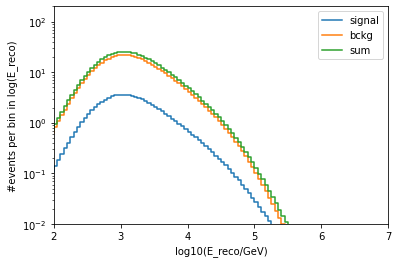

In [258]:
plt.plot(logE_reco_mids, k_s.sum(axis=0), ds="steps-mid", label="signal")
plt.plot(logE_reco_mids, k_b.sum(axis=0), ds="steps-mid", label="bckg")
plt.plot(logE_reco_mids, k_i.sum(axis=0), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlim(2, 7)
plt.ylim(1E-2, 2E2)
plt.ylabel("#events per bin in log(E_reco)")
plt.xlabel("log10(E_reco/GeV)")
plt.legend()

### DEMO: Significance test Background vs. Background + Signal

In [265]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """

    mu_b = atmo_background(
        mu_b_base * x[0], array_source_interp(np.radians(1), bckg_flux_vals.T).T
    )
    mu_s = astro_flux(
        mu_s_base, emids, e_0, *x[1:]
    )
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (B/S)
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )
 

In [266]:
 mu_b = atmo_background(
        mu_b_base , array_source_interp(dec, bckg_flux_vals.T).T
    )

In [267]:
mu_b

array([[1.53511082e-03, 2.00802473e-03, 2.60832595e-03, ...,
        6.27203700e-10, 4.39392510e-10, 3.00074553e-10],
       [1.53511082e-03, 2.00802473e-03, 2.60832595e-03, ...,
        6.27203700e-10, 4.39392510e-10, 3.00074553e-10],
       [1.53511082e-03, 2.00802473e-03, 2.60832595e-03, ...,
        6.27203700e-10, 4.39392510e-10, 3.00074553e-10],
       ...,
       [1.53511082e-03, 2.00802473e-03, 2.60832595e-03, ...,
        6.27203700e-10, 4.39392510e-10, 3.00074553e-10],
       [1.53511082e-03, 2.00802473e-03, 2.60832595e-03, ...,
        6.27203700e-10, 4.39392510e-10, 3.00074553e-10],
       [1.53511082e-03, 2.00802473e-03, 2.60832595e-03, ...,
        6.27203700e-10, 4.39392510e-10, 3.00074553e-10]])

In [268]:
mu_b.sum()

138.00780309661184

In [269]:
local_llh = []
xs = np.linspace(0,500,10)
for x in xs:
    local_llh.append(ps_llh_2d_composite(
    (x, 2.7, 0), mu_b_base, mu_s_base, k_i
    ))

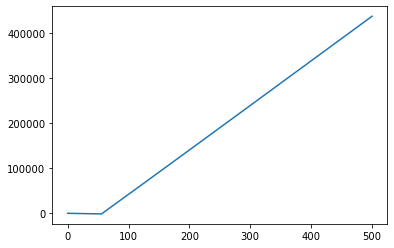

In [270]:
plt.plot(xs, local_llh)

In [250]:
# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 2.7, 0), mu_b_base, mu_s_base, k_i
)
# background + signal, 3 free parameters
global_llh = lambda x: ps_llh_2d_composite(
    x, mu_b_base, mu_s_base, k_i
)
# ... and fit both hypotheses!
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

# calculate p-value and significance with Wilks' and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)

significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


Bckg-only normalization: [5187.93581417]
Signal fit parameters: [ 5.44292228e+03  3.77518049e-01 -1.34242140e+03]
P-VALUE: 0.0 SIGNIFICANCE: inf
